In [183]:
import networkx as nx
import pylab
import numpy as np
import csv
from heapq import heappush, heappop
import copy
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model

# Data processing to create a graph

In [192]:
# read in the data and store it in an adjacency matrix
graph_data = [[] for _ in range(35)]
with open('graph_data.csv') as csv_file:
    # graph_data.csv contains info on the distances between the nodes.
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i = 0
    for row in csv_reader:
        for j in range(i):
            graph_data[i].append(graph_data[j][i])
        for k in range(len(graph_data[i]), 35):
            if row[k] == '':
                graph_data[i].append(0.)
            else:
                graph_data[i].append(float(row[k]))
        i += 1
# adj_matrix[i,j] gives the distance between node i and j
# If node i and j are not neighbor, distance equals 0
adj_matrix = np.array(graph_data)


In [193]:
# build data for the rate lambda of emergency.

# rate is the number of emergency calls per minute

# rate_map[i] gives the lambda for node i
rate_map = {}

# for nodes [1,2,3,4,5]
for i in [1,2,3,4,5]:
    rate_map[i] = 1/30 # average 1 mergenecy call every 30 minutes 
for i in [6,7,9,10,11]:
    rate_map[i] = 1/26 # average 1 mergenecy call every 20 minutes 
for i in [8,15,16,17]:
    rate_map[i] = 1/20 # average 1 mergenecy call every 10 minutes
for i in [12, 13, 14, 19]:
    rate_map[i] = 1/25 # average 1 mergenecy call every 15 minutes 
for i in [18,20]:
    rate_map[i] = 1/16 # average 1 mergenecy call every 16 minutes 
for i in [21,22,23]:
    rate_map[i] = 1/22 # average 1 mergenecy call every 15 minutes 
for i in [26,27,28,29]:
    rate_map[i] = 1/21 # average 1 mergenecy call every 15 minutes 
for i in [24,25,30]:
    rate_map[i]= 1/24 # average 1 mergenecy call every 15 minutes 
for i in [31,32,33]:
    rate_map[i] = 1/28 # average 1 mergenecy call every 15 minutes 
for i in [34,35]:
    rate_map[i] = 1/31 # average 1 mergenecy call every 15 minutes 
rate_map

{1: 0.03333333333333333,
 2: 0.03333333333333333,
 3: 0.03333333333333333,
 4: 0.03333333333333333,
 5: 0.03333333333333333,
 6: 0.038461538461538464,
 7: 0.038461538461538464,
 8: 0.05,
 9: 0.038461538461538464,
 10: 0.038461538461538464,
 11: 0.038461538461538464,
 12: 0.04,
 13: 0.04,
 14: 0.04,
 15: 0.05,
 16: 0.05,
 17: 0.05,
 18: 0.0625,
 19: 0.04,
 20: 0.0625,
 21: 0.045454545454545456,
 22: 0.045454545454545456,
 23: 0.045454545454545456,
 24: 0.041666666666666664,
 25: 0.041666666666666664,
 26: 0.047619047619047616,
 27: 0.047619047619047616,
 28: 0.047619047619047616,
 29: 0.047619047619047616,
 30: 0.041666666666666664,
 31: 0.03571428571428571,
 32: 0.03571428571428571,
 33: 0.03571428571428571,
 34: 0.03225806451612903,
 35: 0.03225806451612903}

In [194]:
# check if the adjacency matrix we have just built is symmetric, which is 
# a requirement for adj matrix for undirected graph.
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    # code from https://stackoverflow.com/a/42913743
    return np.allclose(a, a.T, rtol=rtol, atol=atol)
check_symmetric(adj_matrix) # correct!

True

In [195]:
# DEMO: create graph from the adjacency matrix
# create_using = None uses the default Graph() type, which is undirected graph 
# the weights of the edge between node x and node y can be accessed by g.edges[(x,y)]['weight']
g = nx.from_numpy_matrix(adj_matrix, create_using=None)


In [196]:
# DEMO: the weight/distance between node 0 and 1.
g.edges[0,1]['weight']

1.6

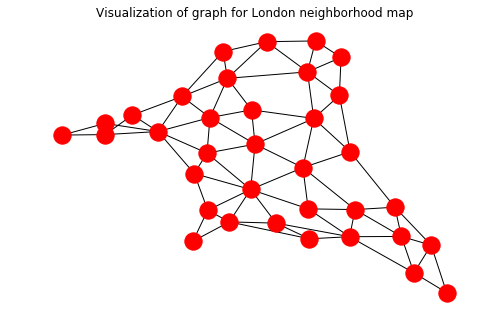

In [197]:
# DEMO: visualize graph
# nx.draw(g)
g.pos = nx.spring_layout(g)
nx.draw(g, pos=g.pos)
pylab.title('Visualization of graph for London neighborhood map')
pylab.show()

# Set rates

In [199]:
for i in g.nodes:
    g.nodes[i]['rate'] = rate_map[i+1]

# Set Despots

## Functions for K-medoids algorithm

In [200]:
def cost(g, medoids):
    """
    Compute the cost of a choice of a set of medoids.
    The cost is the total distances of the nodes to their respective medoids.
    """
    # loop through non-medoid nodes
    cost = 0
    for i in g.nodes:
        if i in medoids: # skip medoids
            continue
        # compute the distance to the nearest medoid
        # Distance is computed using Dijkstra algorithm. 
        # nx.algorithms.shortest_paths.weighted.single_source_dijkstra returns distance and path
        # so we need to subscript [0] to access the distance.
        dist=min([nx.algorithms.shortest_paths.weighted.single_source_dijkstra(g, i, medoid)[0] for medoid in medoids])
        
        # add the distance to cost
        cost += dist
    return cost

def kmedoid_clustering(g, k):
    """
    Cluster the nodes into k clusters, with k nodes being designated as the centers.
    In the context of ambulance allocation, these centers are used as despots, and the
    number of ambulances is proportional to the overall rate of emergency in that cluster.
    """
    # randomly select k nodes as medoids
    medoids = list(np.random.choice(list(g.nodes), k, replace=False))

    # compute the cost of this initiation. The distance between two nodes is taken to be the length of the weighted 
    # shortest path between two nodes (using Djikstra algorithm. See function cost)
    lowest_cost = cost(g, medoids)

    while True:
        # construct a list of non-medoid nodes
        non_medoids = list(g.nodes)[:]
        for m in medoids:
            non_medoids.remove(m) 
            
        # loop through the pair (m,o) of medoid and nonmedoid
        proposed_swap = []
        for m in medoids:
            for o in non_medoids:
                # consider swapping the medoid - nonmedoid status of these two nodes
                # we first compute the cost of such a swap. We record the reduction in cost of
                # such a swap. Later, we will do the swap with the largest reduction in cost.
                proposed_medoids = medoids[:]
                proposed_medoids.remove(m)
                proposed_medoids.append(o)
                # compute the new cost
                proposed_cost = cost(g, proposed_medoids)
                # record the cost reduction and the pair
                cost_reduction = lowest_cost - proposed_cost
                proposed_swap.append((cost_reduction, (m,o)))
        # sort the proposed pairs of swap according to the reduction in cost:
        proposed_swap.sort(reverse=True)
        # if there is no improvement in all the proposed swaps, we don't swap and 
        # terminate the algorithm
        if proposed_swap[0][0] <= 0:
            break
        else: 
            # update the new lowest cost:
            lowest_cost -= proposed_swap[0][0]
            # update the new medoids:
            m,o = proposed_swap[0][1]
            medoids.remove(m)
            medoids.append(o)
    return medoids


def kmedoid_alloc(g, num_amb, medoids):
    """
    Given a list of medoids, allocate the ambulances to them. The number of ambulances allocated
    is proportional to the rate of emergency in the area.
    
    Inputs:
        - g: Graph of the city
        - num_amb: int, number of ambulances
        - medoids: list of ints, list of medoids
    """
    # create a cluster dictionary
    clusters = {i:[i] for i in medoids} # cluster[i] gives the list of nodes in the cluster with node i as
                                        # the medoid
    
    # loop through non-medoid nodes and add them to the appropriate cluster
    for i in g.nodes:
        if i in medoids:
            continue
        dist_list = [(nx.algorithms.shortest_paths.weighted.single_source_dijkstra(g, i, medoid), medoid) for medoid in medoids]
        dist_list.sort()
        clusters[dist_list[0][1]].append(i)
    
    # create a rate_map dictionary
    rate_map = {i: 0 for i in medoids} # rate_map[i] gives the relative rate of emergency of cluster i
    total_rate = 0 # in the end, total_rate is the sum of the lambdas of all the nodes
    for cluster, nodes in clusters.items():
        for node in nodes:
            total_rate += g.nodes[node]['rate']
            rate_map[cluster] += g.nodes[node]['rate']
    for cluster in rate_map:
        rate_map[cluster] /= total_rate
    
    # distribute ambulances to the despots/medoids proportional to the relative rate in rate_map
    # by updating attribute 'despot' of the node.
    # if 'despot' = 0, no ambulance and the node is not a designated despot.
    # if 'despot' = 3, there are 3 ambulances allocated at the node.
    for i in medoids[:-1]:
        g.nodes[i]['despot'] = int(num_amb * rate_map[i])
    g.nodes[medoids[-1]]['despot'] = num_amb - sum([g.nodes[i]['despot'] for i in medoids[:-1]])
    
    # for those nodes that are not designated despots, the number of ambulance is 0:
    for i in g.nodes:
        if not i in medoids:
            g.nodes[i]['despot'] = 0
    return g


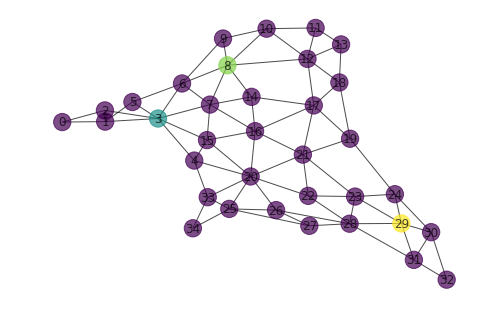

In [201]:
# DEMO. We see that the three medoids/ despots are: 3, 8, 29
medoids = kmedoid_clustering(g, k=3)
g = kmedoid_alloc(g, num_amb=100, medoids=medoids)
nx.draw(g, pos=g.pos, with_labels=True, 
       node_color=[g.nodes[i]['despot'] for i in g.nodes],
       alpha=.7)

# Experiment on the consistency of K-medoids algorithm

## k = 1

In [103]:
# run kmedoids 100 times and record what is returned as medoids.
def kmedoids_freq(g, k):
    alloc_results = {}
    for _ in range(100):
        medoids = kmedoid_clustering(g, k=k)
        medoids.sort()
        if not tuple(medoids) in alloc_results:
            alloc_results[tuple(medoids)] = 1
        else:
            alloc_results[tuple(medoids)] += 1
    return alloc_results


In [104]:
# we see that for all 100 times, [17] is picked as the medoid.
alloc_results1 = kmedoids_freq(g,k=1)
print(alloc_results1)

{(17,): 100}


## k = 2

In [105]:
alloc_results2 = kmedoids_freq(g,k=2)
print(alloc_results2)

{(8, 28): 100}


## k = 3

In [107]:
alloc_results3 = kmedoids_freq(g,k=3)
print(alloc_results3)

{(3, 8, 29): 100}


## k = 4

In [136]:
alloc_results4 = kmedoids_freq(g,k=4)
print(alloc_results4)

{(1, 8, 20, 29): 45, (3, 8, 23, 25): 21, (0, 4, 8, 29): 11, (3, 8, 21, 28): 23}


## k = 5

In [109]:
alloc_results5 = kmedoids_freq(g,k=5)
print(alloc_results5)

{(1, 8, 20, 23, 25): 9, (3, 8, 18, 25, 29): 5, (1, 8, 19, 20, 28): 42, (1, 8, 18, 20, 29): 5, (0, 4, 8, 19, 28): 12, (1, 8, 20, 23, 27): 5, (3, 6, 8, 21, 28): 3, (3, 8, 21, 25, 30): 9, (0, 8, 15, 23, 25): 6, (1, 8, 17, 29, 33): 2, (0, 4, 8, 18, 29): 1, (3, 8, 19, 25, 29): 1}


# Code for main simulation

In [118]:
class Event:
    
    def __init__(self, event_type, t0, location, max_wait_time=None, difficulty_level=None, request=None):
        """
        Inputs:
        - event_type: str, either 'request' (a request is sent), 'amb_arrive' (an ambulance has arrived at
        the location of emergency), or 'amb_complete' (an ambulance has gotten back to its despot after finishing
        servicing)
        - t0: float, point in time the event occurs
        - location: int, if event_typpe is 'request', its where the emergency occurs,
        if event_Type is ambulance-related ('amb_arrive' or 'amb_complete'), location is the despot the ambulance 
        was sent from.
        - max_wait_time: float, time_max variable in the main report, the maximum a patient can wait for an 
        ambulance to come. Beyond this wait time, patient dies.
        - difficulty_level: int, taken from [1,2,3]. 1 means ambulance will take 10 minutes to attend the case
        after arriving, 2 means 20 and 3 means 30 minutes.
        - request: an Event with event_type = 'request'. This is set only if event_type is ambulance related.
        this is the request the ambulance is servicing. 
        """
        self.event_type = event_type
        self.t0 = t0
        self.location = location
        
        if self.event_type == 'request':
            if max_wait_time is None:
                raise ValueError('max_wait_time must be specified for "request" event_type')
            if difficulty_level is None:
                raise ValueError('difficulty_level must be specified for "request" event_type')
            self.max_wait_time = max_wait_time
            self.difficulty_level = difficulty_level
            
        elif self.event_type in ['amb_arrive', 'amb_complete']:
            if request is None:
                raise ValueError('request must be specified for "amb_arrive" or "amb_complete" event_type')
            self.request = request
            
        
    def __lt__(self, other):
        # overload the < operator so we can sort events.
        self.t0 < other.t0

def request_gen(g, mu, std, time_end):
    """
    - g: the graph
    - mu, std: parameters of the Normal distribution N. The maximum time a call can wait until
    the ambulance gets to the location of the call is taken from N.
    - time_end: int, the maximum point in time a request can be sent. If time_end's unit is hours, and
    we only look to model 1 day, then time_end=24.
    """
    num_nodes = len(g.nodes)
    requests = []
    for location in range(num_nodes):
        t = 0
        while t <= time_end: 
            t = t + np.random.exponential(scale=1/g.nodes[location]['rate'])
            # maximum wait time is drawn from Normal with mean mu and variance std^2
            while True:
                max_wait_time = np.random.normal(loc=mu, scale=std)
                if max_wait_time > 0:
                    break
            # choosing difficulty level from 1, 2, or 3 with weights [.3, .6, .1]
            difficulty_level = np.random.choice([1,2,3], p=[.3, .6, .1,])
            r = Event(event_type='request', t0=t, location=location, 
                      max_wait_time=max_wait_time, difficulty_level=difficulty_level)
            heappush(requests, r)
    requests.sort()
    return requests

def naive_alloc(g, num_amb):
    """
    Evenly distribute num_amb ambulances to all the nodes in g.
    - num_amb: number of ambulances
    """
    num_nodes = len(list(g.nodes))
    for i in range(len(g.nodes)-1):
        g.nodes[i]['despot'] = num_amb // num_nodes
    g.nodes[int(len(g.nodes)-1)]['despot'] = num_amb//num_nodes + num_amb%num_nodes
    return g

class Sim:
    amb_avg_speed = 30 # mph
    def __init__(self, g, mu, std, time_end, num_amb, alloc_strategy, medoids=None):
        """
        - mu, std, time_end: see `request_gen`
        - num_amb: int, number of ambulances in the city
        - alloc_strategy: str, either 'naive', or 'medoids'
        - medoids: list of ints, list of medoids. Specified iff alloc_strategy == 'medoids'
        """
        self.g = g
        self.mu = mu
        self.std = std
        self.time_end = time_end
        self.num_amb = num_amb
        self.alloc_strategy = alloc_strategy
        
        # distribute the ambulances according to the allocation strategy specified in alloc_strategy
        if alloc_strategy == 'naive':
            self.g = naive_alloc(self.g, self.num_amb)
        elif alloc_strategy == 'kmedoids':
            if medoids is None:
                raise ValueError('medoids must be specified if alloc_strategy is "kmedoids"')
            self.k = k
            self.medoids = medoids
            self.g = kmedoid_alloc(self.g, self.num_amb, self.medoids)
            
        # compute the number of ambulances from graph g
#         self.num_amb = np.sum([self.g.nodes[i]['despot'] for i in self.g.nodes])
        
        # compute the number of despots:
        self.num_despots = np.sum([self.g.nodes[i]['despot'] for i in self.g.nodes])
                
        # create a list of despots from g:
        self.despot_lst = [i for i in self.g.nodes if self.g.nodes[i]['despot'] ]
        
        # the number of free ambulances 
        self.num_free_amb = self.num_amb
        
        
    
        
    def _find_despot(self, r):
        shortest_dist = float('inf')
        chosen_despot = None
        for despot in self.despot_lst:
            if g.nodes[despot]['despot'] > 0:
                distance, _ = nx.algorithms.shortest_paths.weighted.single_source_dijkstra(self.g, despot, r.location)
                if distance < shortest_dist:
                    shortest_dist = distance
                    chosen_despot = despot
        return chosen_despot, distance
    
    def dispatch(self, current_event, requests_on_hold, events):
        """
        current_event is also in requests_on_hold if it's a request
        """
        despot_chosen = None
        # if there is no free ambulances
        if self.num_free_amb == 0:
            return None
        else: # if there is at least one free ambulance
            for i in range(len(requests_on_hold)):
                r = requests_on_hold[i]
                # if the patient has died, we don't send the ambulance.
                if r.t0 + r.max_wait_time < current_event.t0:
                    continue
                else: # send ambulance to service this request
                    # find the despot that has free ambulance and closest to the location of request
                    despot_chosen, distance_travelled = self._find_despot(r)
                    # update the number of ambulances left at the chosen despot after dispatching
                    self.g.nodes[despot_chosen]['despot'] -= 1
                    # add the scheduled arrival time of the ambulance to `events` list:
                    t_arrive = r.t0 + 60*distance_travelled/self.amb_avg_speed + np.random.normal(loc=.2*60*distance_travelled/self.amb_avg_speed, scale=1)
                    heappush(events, Event(event_type='amb_arrive', 
                                           t0 = t_arrive,
                                           location=despot_chosen,
                                           request=r))
                    # add the scheduled finishing time of the ambulance to `events` list:
                    avg_attending_time = 10*r.difficulty_level
                    heappush(events, Event(event_type='amb_complete', 
                                          t0 = t_arrive + np.random.normal(loc=avg_attending_time, scale=1) + 60*distance_travelled/self.amb_avg_speed,
                                          location=despot_chosen,
                                          request=r))
                    # update the total number of free ambulances
                    self.num_free_amb -= 1
                    break
        #  update the requests on hold list to only contain those that are left unattended
        requests_on_hold = requests_on_hold[i+1:]           
        return requests_on_hold, events
  
        
    def sim(self):
        """
        This returns waiting_times (the list of the amounts of time patients have to wait until an
        ambulance comes) and deaths (the number of death resulted from not timely arrive ambulances)
        """
        deaths = 0 # keeps track of the number of deaths resulting from late arrival, to be returned in the end
        events = request_gen(self.g, self.mu, self.std, self.time_end) # generate requests
        requests_on_hold = [] # requests that there have been no ambulances sent for
        waiting_times = [] # the list of waiting times, to be returned in the end
        # gradually pop event from the list of events to process
        while events:
            e = heappop(events)
            # if it is a request
            if e.event_type == 'request':
                # put the request on hold and try to send an ambulance if possible by calling `dispatch`
                requests_on_hold.append(e)
                try:
                    requests_on_hold, events = self.dispatch(e, requests_on_hold, events) 
                except:
                    pass
            # the an ambulance has arrived
            elif e.event_type == 'amb_arrive':
                # the ambulance has arrived, and we need to check if the patient has died to update the deaths
                if e.request.t0 + e.request.max_wait_time < e.t0: # the patient has died
                    deaths += 1
                # compute the patient's waiting time (from the time the request is sent to when the ambulance
                # arrives)
                waiting_times.append(e.t0 - e.request.t0)
           
            elif e.event_type == 'amb_complete':
                # update the number of free ambulance at the despot
                self.g.nodes[e.location]['despot'] += 1
                if self.num_free_amb == 0: # previously no free ambulances and now there is one that's just come back
                                           # we need to check if there is any requests on hold to attend to
                        self.num_free_amb += 1
                        if requests_on_hold:
                            requests_on_hold, events = self.dispatch(e, requests_on_hold, events) 
        return deaths, waiting_times
        

# Strategy 1: Total Naive

In [115]:
# create the graph
g = nx.from_numpy_matrix(adj_matrix, create_using=None)
for i in g.nodes:
    g.nodes[i]['rate'] = rate_map[i+1]

# simulate 500 times
death_rates = []
avg_waiting_times = []
for i in range(500):
    if (i+1)%20 == 0:
        print('Finished %d/500'%(i+1))
    emergency_sim = Sim(g, mu=15, std=1, time_end=60*24, num_amb=100, alloc_strategy='naive')
    deaths, waiting_times = emergency_sim.sim()
    death_rates.append(deaths/len(waiting_times))
    avg_waiting_times.append(sum(waiting_times)/len(waiting_times))


Finished 20/500
Finished 40/500
Finished 60/500
Finished 80/500
Finished 100/500
Finished 120/500
Finished 140/500
Finished 160/500
Finished 180/500
Finished 200/500
Finished 220/500
Finished 240/500
Finished 260/500
Finished 280/500
Finished 300/500
Finished 320/500
Finished 340/500
Finished 360/500
Finished 380/500
Finished 400/500
Finished 420/500
Finished 440/500
Finished 460/500
Finished 480/500
Finished 500/500


# Strategy 2: K-medoids Clustering


In [121]:
# k = 1
# create the graph
g = nx.from_numpy_matrix(adj_matrix, create_using=None)
for i in g.nodes:
    g.nodes[i]['rate'] = rate_map[i+1]
# medoids:
medoids = [17]
#simulate 500 times:
death_rates1 = []
avg_waiting_times1 = []
for i in range(1000):
    if (i+1)%100 == 0:
        print('Finished %d/1000'%(i+1))
    emergency_sim = Sim(g, mu=15, std=1, time_end=60*24, num_amb=100, alloc_strategy='kmedoids', medoids=medoids)
    deaths, waiting_times = emergency_sim.sim()
    death_rates1.append(deaths/len(waiting_times))
    avg_waiting_times1.append(sum(waiting_times)/len(waiting_times))

Finished 100/1000
Finished 200/1000
Finished 300/1000
Finished 400/1000
Finished 500/1000
Finished 600/1000
Finished 700/1000
Finished 800/1000
Finished 900/1000
Finished 1000/1000


In [123]:
# k = 2

# create the graph
g = nx.from_numpy_matrix(adj_matrix, create_using=None)
for i in g.nodes:
    g.nodes[i]['rate'] = rate_map[i+1]
# medoids:
medoids = [8,28]
#simulate 10000 times:
death_rates2 = []
avg_waiting_times2 = []
for i in range(1000):
    if (i+1)%100 == 0:
        print('Finished %d/1000'%(i+1))
    emergency_sim = Sim(g, mu=15, std=1, time_end=60*24, num_amb=100, alloc_strategy='kmedoids', medoids=medoids)
    deaths, waiting_times = emergency_sim.sim()
    death_rates2.append(deaths/len(waiting_times))
    avg_waiting_times2.append(sum(waiting_times)/len(waiting_times))

Finished 100/1000
Finished 200/1000
Finished 300/1000
Finished 400/1000
Finished 500/1000
Finished 600/1000
Finished 700/1000
Finished 800/1000
Finished 900/1000
Finished 1000/1000


In [126]:
# k = 3

# create the graph
g = nx.from_numpy_matrix(adj_matrix, create_using=None)
for i in g.nodes:
    g.nodes[i]['rate'] = rate_map[i+1]
# medoids:
medoids = [3, 8, 29]
#simulate 10000 times:
death_rates3 = []
avg_waiting_times3 = []
for i in range(1000):
    if (i+1)%100 == 0:
        print('Finished %d/1000'%(i+1))
    emergency_sim = Sim(g, mu=15, std=1, time_end=60*24, num_amb=100, alloc_strategy='kmedoids', medoids=medoids)
    deaths, waiting_times = emergency_sim.sim()
    death_rates3.append(deaths/len(waiting_times))
    avg_waiting_times3.append(sum(waiting_times)/len(waiting_times))

Finished 100/1000
Finished 200/1000
Finished 300/1000
Finished 400/1000
Finished 500/1000
Finished 600/1000
Finished 700/1000
Finished 800/1000
Finished 900/1000
Finished 1000/1000


In [137]:
# k = 4

# create the graph
g = nx.from_numpy_matrix(adj_matrix, create_using=None)
for i in g.nodes:
    g.nodes[i]['rate'] = rate_map[i+1]

death_rates4 = []
avg_waiting_times4 = []

# simulate
k = 0
for medoid_set in alloc_results4:
    medoids = list(medoid_set)
    for _ in range(10*alloc_results4[medoid_set]):
        if (k+1)%100 == 0:
            print('Finished %d/1000'%(k+1))
        emergency_sim = Sim(g, mu=15, std=1, time_end=60*24, num_amb=100, alloc_strategy='kmedoids', medoids=medoids)
        deaths, waiting_times = emergency_sim.sim()
        death_rates4.append(deaths/len(waiting_times))
        avg_waiting_times4.append(sum(waiting_times)/len(waiting_times))
        k += 1



Finished 100/1000
Finished 200/1000
Finished 300/1000
Finished 400/1000
Finished 500/1000
Finished 600/1000
Finished 700/1000
Finished 800/1000
Finished 900/1000
Finished 1000/1000


In [127]:
# k = 5

# create the graph
g = nx.from_numpy_matrix(adj_matrix, create_using=None)
for i in g.nodes:
    g.nodes[i]['rate'] = rate_map[i+1]

death_rates5 = []
avg_waiting_times5 = []

# simulate
k = 0
for medoid_set in alloc_results5:
    medoids = list(medoid_set)
    for _ in range(10*alloc_results5[medoid_set]):
        if (k+1)%100 == 0:
            print('Finished %d/1000'%(k+1))
        emergency_sim = Sim(g, mu=15, std=1, time_end=60*24, num_amb=100, alloc_strategy='kmedoids', medoids=medoids)
        deaths, waiting_times = emergency_sim.sim()
        death_rates5.append(deaths/len(waiting_times))
        avg_waiting_times5.append(sum(waiting_times)/len(waiting_times))
        k += 1


Finished 100/1000
Finished 200/1000
Finished 300/1000
Finished 400/1000
Finished 500/1000
Finished 600/1000
Finished 700/1000
Finished 800/1000
Finished 900/1000
Finished 1000/1000


# Results

## Strategy 1


Average death rate: 0.23664389057234225
95% confidence interval:[0.1836479151623444 ; 0.26968433330903263]


Text(0.5,1,'Histogram for death rates of naive strategy')

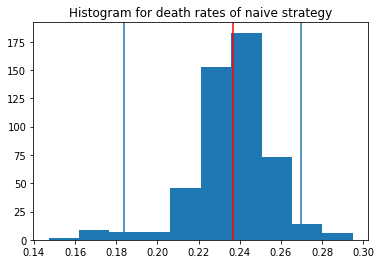

In [151]:
print('Average death rate:', sum(death_rates)/len(death_rates))
quantiles = np.quantile(death_rates, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(death_rates)
plt.axvline(x=sum(death_rates)/len(death_rates), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for death rates of naive strategy')


Mean of average waiting time: 9.036919494848565
95% confidence interval:[8.521205090515238 ; 10.277552248436317]


Text(0.5,1,'Histogram for average waiting times\n for naive strategy')

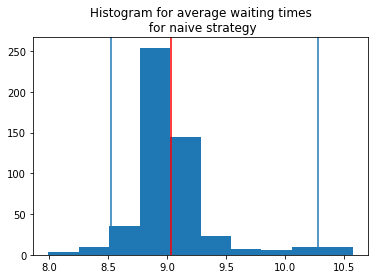

In [156]:
print('Mean of average waiting time:', sum(avg_waiting_times)/len(avg_waiting_times))
quantiles = np.quantile(avg_waiting_times, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(avg_waiting_times)
plt.axvline(x=sum(avg_waiting_times)/len(avg_waiting_times), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for average waiting times\n for naive strategy')

## Strategy K=1

Average death rate: 0.016355176129520504
95% confidence interval:[0.005990977443609023 ; 0.028758616438778337]


Text(0.5,1,'Histogram for death rates of K=1 strategy')

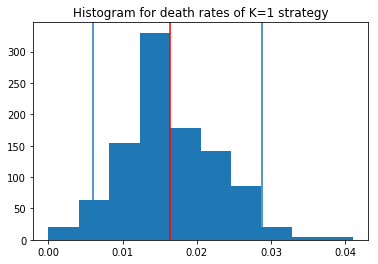

In [155]:
print('Average death rate:', sum(death_rates1)/len(death_rates1))
quantiles = np.quantile(death_rates1, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(death_rates1)
plt.axvline(x=sum(death_rates1)/len(death_rates1), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for death rates of K=1 strategy')


Mean of average waiting time: 7.485035581109652
95% confidence interval:[6.606782698358771 ; 7.760243956439497]


Text(0.5,1,'Histogram for average waiting times\n for K=1 strategy')

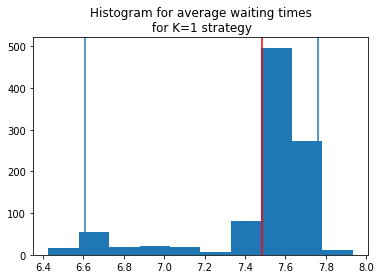

In [157]:
print('Mean of average waiting time:', sum(avg_waiting_times1)/len(avg_waiting_times1))
quantiles = np.quantile(avg_waiting_times1, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(avg_waiting_times1)
plt.axvline(x=sum(avg_waiting_times1)/len(avg_waiting_times1), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for average waiting times\n for K=1 strategy')

## K=2 strategy

Average death rate: 0.1483237175345279
95% confidence interval:[0.10370178468624064 ; 0.171875]


Text(0.5,1,'Histogram for death rates of K=2 strategy')

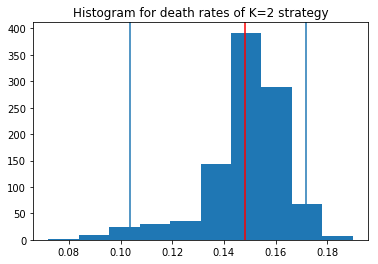

In [158]:
print('Average death rate:', sum(death_rates2)/len(death_rates2))
quantiles = np.quantile(death_rates2, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(death_rates2)
plt.axvline(x=sum(death_rates2)/len(death_rates2), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for death rates of K=2 strategy')

Mean of average waiting time: 8.185010125165554
95% confidence interval:[7.120309266571499 ; 8.570715503240663]


Text(0.5,1,'Histogram for average waiting times\n for K=2 strategy')

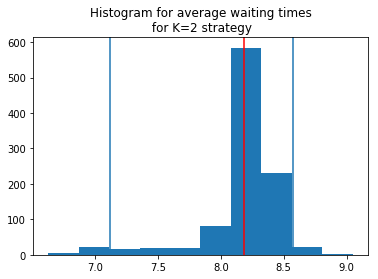

In [159]:
print('Mean of average waiting time:', sum(avg_waiting_times2)/len(avg_waiting_times2))
quantiles = np.quantile(avg_waiting_times2, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(avg_waiting_times2)
plt.axvline(x=sum(avg_waiting_times2)/len(avg_waiting_times2), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for average waiting times\n for K=2 strategy')

## K=3 strategy

Average death rate: 0.10562491903799982
95% confidence interval:[0.06829406291851241 ; 0.12808738425925925]


Text(0.5,1,'Histogram for death rates of K=3 strategy')

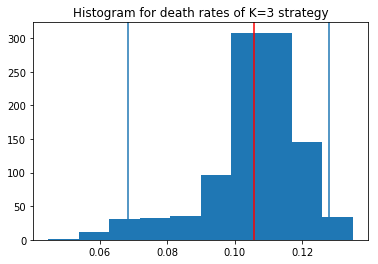

In [162]:
print('Average death rate:', sum(death_rates3)/len(death_rates3))
quantiles = np.quantile(death_rates3, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(death_rates3)
plt.axvline(x=sum(death_rates3)/len(death_rates3), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for death rates of K=3 strategy')

Mean of average waiting time: 7.896788460989932
95% confidence interval:[6.747069034949632 ; 8.252648409858923]


Text(0.5,1,'Histogram for average waiting times\n for K=3 strategy')

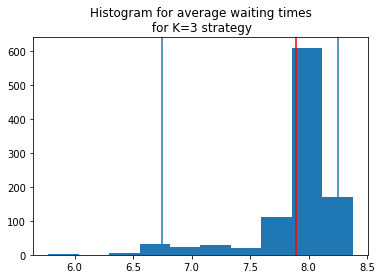

In [161]:
print('Mean of average waiting time:', sum(avg_waiting_times3)/len(avg_waiting_times3))
quantiles = np.quantile(avg_waiting_times3, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(avg_waiting_times3)
plt.axvline(x=sum(avg_waiting_times3)/len(avg_waiting_times3), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for average waiting times\n for K=3 strategy')

# K=4 strategy

Average death rate: 0.12921896172275654
95% confidence interval:[0.06941434574818721 ; 0.19169655595073037]


Text(0.5,1,'Histogram for death rates of K=4 strategy')

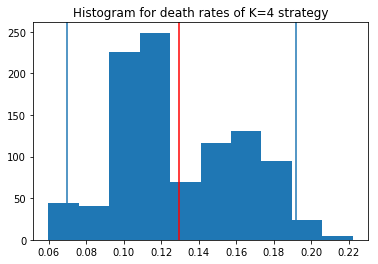

In [164]:
print('Average death rate:', sum(death_rates4)/len(death_rates4))
quantiles = np.quantile(death_rates4, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(death_rates4)
plt.axvline(x=sum(death_rates4)/len(death_rates4), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for death rates of K=4 strategy')

Mean of average waiting time: 8.033261045230507
95% confidence interval:[6.987482969237878 ; 8.501108440967576]


Text(0.5,1,'Histogram for average waiting times\n for K=4 strategy')

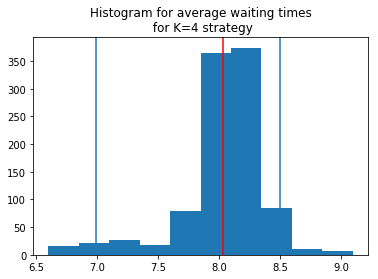

In [168]:
print('Mean of average waiting time:', sum(avg_waiting_times4)/len(avg_waiting_times4))
quantiles = np.quantile(avg_waiting_times4, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(avg_waiting_times4)
plt.axvline(x=sum(avg_waiting_times4)/len(avg_waiting_times4), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for average waiting times\n for K=4 strategy')

## K=5 strategy

Average death rate: 0.14518326629404732
95% confidence interval:[0.08850478574367616 ; 0.18691588785046728]


Text(0.5,1,'Histogram for death rates of K=5 strategy')

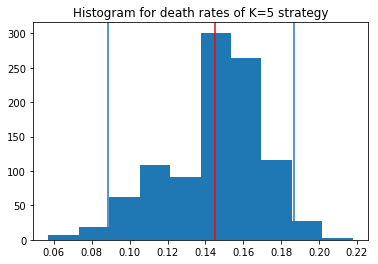

In [165]:
print('Average death rate:', sum(death_rates5)/len(death_rates5))
quantiles = np.quantile(death_rates5, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(death_rates5)
plt.axvline(x=sum(death_rates5)/len(death_rates5), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for death rates of K=5 strategy')

Mean of average waiting time: 8.219832471740965
95% confidence interval:[7.061054724499884 ; 9.250748843845258]


Text(0.5,1,'Histogram for average waiting times\n for K=5 strategy')

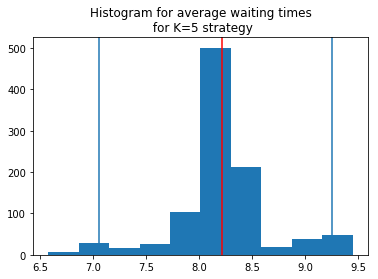

In [167]:
print('Mean of average waiting time:', sum(avg_waiting_times5)/len(avg_waiting_times5))
quantiles = np.quantile(avg_waiting_times5, [.025, .975])
print(f'95% confidence interval:[{quantiles[0]} ; {quantiles[1]}]')
plt.hist(avg_waiting_times5)
plt.axvline(x=sum(avg_waiting_times5)/len(avg_waiting_times5), color='r')
plt.axvline(x=quantiles[0])
plt.axvline(x=quantiles[1])
plt.title('Histogram for average waiting times\n for K=5 strategy')

## Correlation between waiting time and death rates

Coefficients: 
 [0.09612679]
Intercept:
 -0.6543779780718045


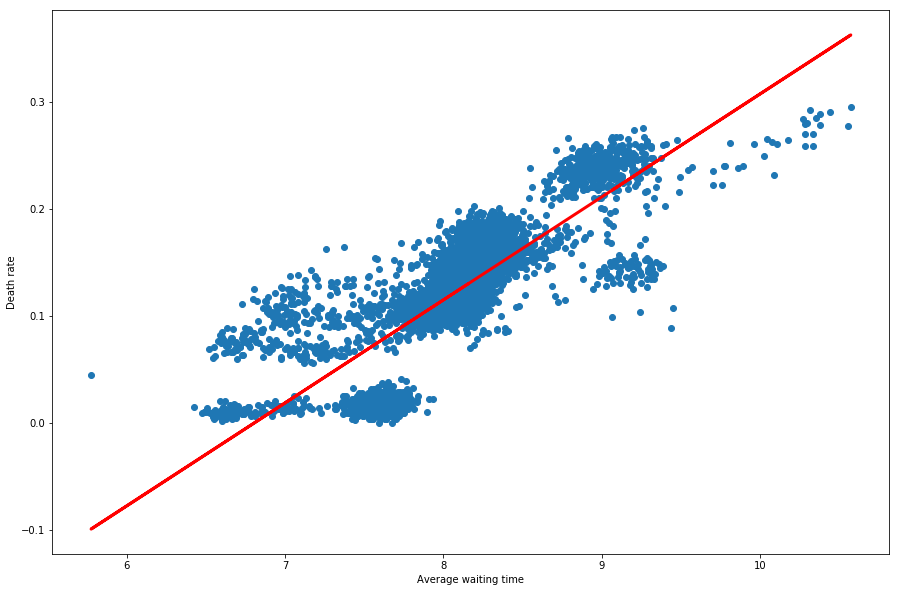

In [185]:
plt.figure(figsize=(15,10))
data_avg_waiting_times = avg_waiting_times+avg_waiting_times1+avg_waiting_times2+avg_waiting_times3+avg_waiting_times4+avg_waiting_times5
data_death_rates = death_rates+death_rates1+death_rates2+death_rates3+death_rates4+death_rates5
plt.scatter(data_avg_waiting_times,
            data_death_rates)
plt.xlabel('Average waiting time')
plt.ylabel('Death rate')
data_avg_waiting_times = [[time] for time in data_avg_waiting_times] 
regr = linear_model.LinearRegression()

# Train the model using the training set
regr.fit(data_avg_waiting_times, data_death_rates)


# Make predictions on training set
death_rates_preds = regr.predict(data_avg_waiting_times)

# The coefficients
print('Coefficients: \n', regr.coef_)
print('Intercept:\n', regr.intercept_)

plt.plot(data_avg_waiting_times, death_rates_preds, color='red', linewidth=3)
# plt.xlabel('Rental price')
# plt.ylabel('Location multiplier')
plt.show()






## Overall results

Text(0,0.5,'Death rate')

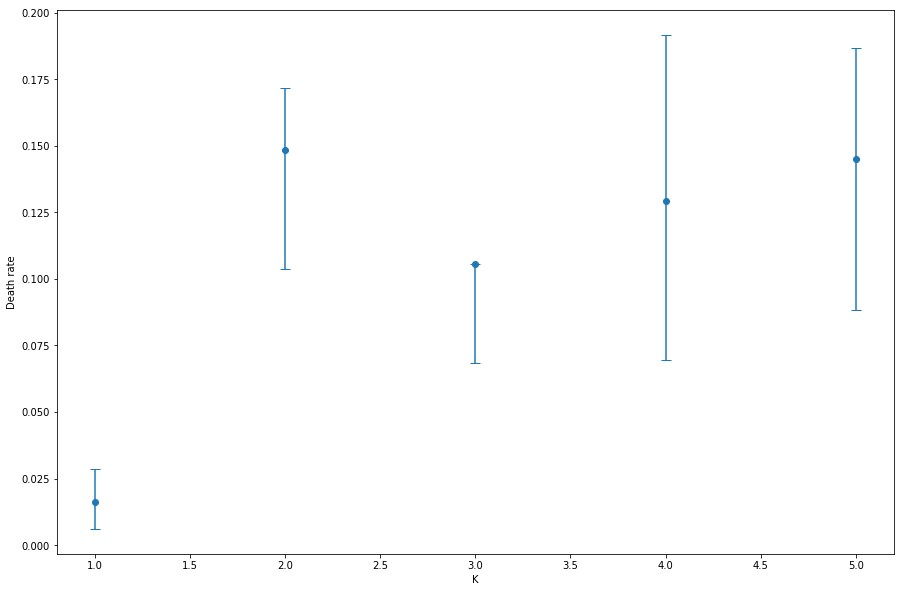

In [188]:
plt.figure(figsize=(15,10))

plt.errorbar(range(1,6), [0.016355176129520504, 0.1483237175345279, 0.10562491903799982, 0.12921896172275654, 0.14518326629404732] , 
             np.array([[0.016355176129520504-0.005990977443609023, 0.1483237175345279-0.10370178468624064,
              0.10562491903799982-0.06829406291851241, 0.12921896172275654-0.06941434574818721,0.14518326629404732-0.08850478574367616],
              [0.028758616438778337-0.016355176129520504, 0.171875-0.1483237175345279,0.12808738425925925-0.12808738425925925,
              0.19169655595073037-0.12921896172275654,0.18691588785046728-0.14518326629404732]]),
            fmt='o', capsize=5)
plt.xlabel('K')
plt.ylabel('Death rate')

Text(0,0.5,'Average waiting time')

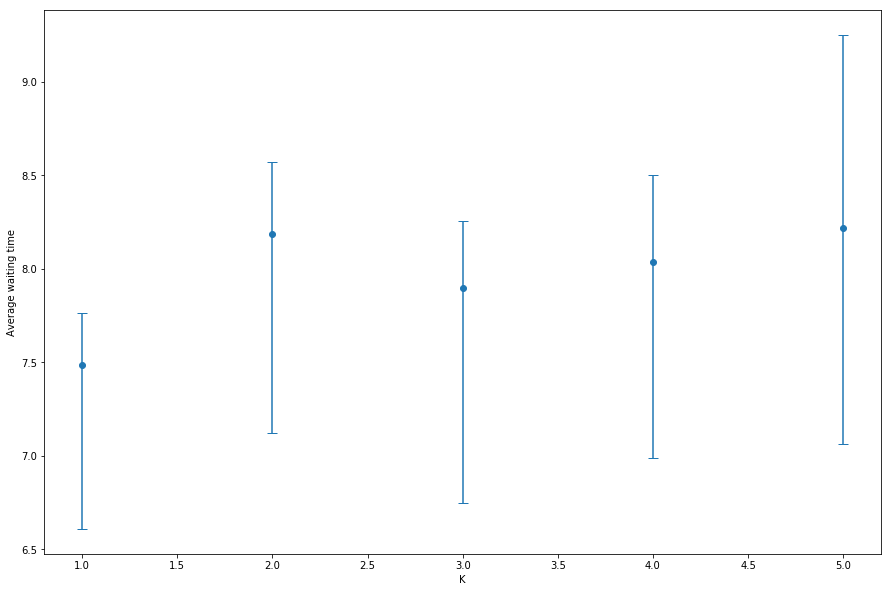

In [190]:
plt.figure(figsize=(15,10))

plt.errorbar(range(1,6), [7.485035581109652, 8.185010125165554, 7.896788460989932, 8.033261045230507, 8.219832471740965] , 
             [[7.485035581109652-6.606782698358771,8.185010125165554-7.120309266571499,7.896788460989932-6.747069034949632,
              8.033261045230507-6.987482969237878,8.219832471740965-7.061054724499884],
              [7.760243956439497-7.485035581109652,8.570715503240663-8.185010125165554,8.252648409858923-7.896788460989932,
              8.501108440967576-8.033261045230507,9.250748843845258-8.219832471740965]],
            fmt='o', capsize=5)
plt.xlabel('K')
plt.ylabel('Average waiting time')